### Objective

In this notebook, we aim to train a surrogate model and use it to propose promising, feasible solution for the downstream optimization tasks.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys

from sklearn.preprocessing import MinMaxScaler, StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from scipy.stats import norm, qmc
import sklearn.gaussian_process as gp
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, max_error, brier_score_loss

import gpflow
import tensorflow as tf
import tensorflow_probability as tfp

### 1. Load dataset

In [2]:
df_train = pd.read_csv('./dataset/passive_learning_train.csv')
df_train.columns = ['Q1', 'Q2', 'd', 'b', 'L', 'c', 'L_duct', 'n', 't', 'xc1', 'yc1', 'xc2', 'yc2', 'Tc', 'Tj', 'w']
print(f"Training pool: {df_train.shape[0]}")

Training pool: 939


In [3]:
# Dedicated testing set
df_test = pd.read_csv('./dataset/test.csv')
df_test.columns = ['Q1', 'Q2', 'd', 'b', 'L', 'c', 'L_duct', 'n', 't', 'xc1', 'yc1', 'xc2', 'yc2', 'Tc', 'Tj', 'w']
print(f"Testing dataset: {df_test.shape[0]}")

Testing dataset: 5655


In [4]:
df_candidates = pd.read_csv('./dataset/candidates.csv')
df_candidates.columns = ['d', 'b', 'L', 'c', 'L_duct', 'n', 't', 'xc1', 'yc1', 'xc2', 'yc2']
print(f"PCandidate pool: {df_candidates.shape[0]}")

PCandidate pool: 470070


In [5]:
df_candidates

,d,b,L,c,L_duct,n,t,xc1,yc1,xc2,yc2
0,0.024521,0.206944,0.506993,0.033988,0.038962,42.0,0.002591,0.148896,0.381335,0.102875,0.117766
1,0.015110,0.188389,0.294450,0.026641,0.020286,41.0,0.001608,0.048841,0.198119,0.116538,0.205286
2,0.014427,0.253633,0.320429,0.017572,0.037478,18.0,0.006704,0.134616,0.076037,0.212379,0.221865
3,0.012051,0.227430,0.353626,0.031238,0.040790,20.0,0.007510,0.136160,0.277024,0.072578,0.268884
4,0.018974,0.283505,0.261873,0.038342,0.040381,40.0,0.003691,0.218187,0.204095,0.110509,0.068614
...,...,...,...,...,...,...,...,...,...,...,...
470065,0.010794,0.219928,0.389518,0.017259,0.032786,35.0,0.001287,0.132040,0.072390,0.181255,0.190358
470066,0.018208,0.222540,0.164801,0.011747,0.035325,35.0,0.001023,0.150087,0.080438,0.074537,0.077828
470067,0.027990,0.078946,0.312942,0.038899,0.037921,35.0,0.001240,0.042084,0.217460,0.043254,0.108684
470068,0.011218,0.191438,0.142435,0.027854,0.042275,30.0,0.003645,0.053933,0.086435,0.150572,0.077488


In [6]:
def create_samples(df, train_num):
   
    # Create dataset
    X = df.iloc[:, :-3].to_numpy()
    y = df.iloc[:, -2].to_numpy()
    
    # Train-test split
    if train_num < len(df):
        test_size = 1-train_num/len(df)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    else:
        X_train, y_train = X, y
        X_test, y_test = None, None
    
    return X_train, X_test, y_train, y_test

In [7]:
# Train-test split
X_train, _, y_train, _ = create_samples(df_train, len(df_train))
X_test, _, y_test, _ = create_samples(df_test, len(df_test))

# Normalization
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 2. Model training

In [8]:
def evaluate_model(y_true, y_pred):
    """This function is used for evaluating the ML models performance."""
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    max_e = max_error(y_true, y_pred)
    
    percentage = np.abs(y_true-y_pred)/y_true
    max_percentage = np.max(percentage)*100
    max_percentage_loc = np.argmax(percentage)
    mean_percentage = np.mean(percentage)*100
    
    return rmse, max_e, max_percentage, max_percentage_loc, mean_percentage

#### Standard Gaussian Process

In [11]:
def init_length_scales(dim, n_restarts, initial_guess=None):
    
    # Random initial params
    lb, ub = -2, 2
    lhd = qmc.LatinHypercube(d=dim, seed=42).random(n_restarts)
    lhd = (ub-lb)*lhd + lb
    length_scales = 10**lhd

    # Informed initial guess
    if initial_guess is not None:
        length_scales = np.vstack((length_scales, initial_guess))

    return length_scales

In [12]:
def fit(X, y, n_restarts=20, init_lengthscales=None, init_variance=None, trainable=True, verbose=True):
    models = []
    log_likelihoods = []
    
    # Generate initial guesses for length scale
    length_scales = init_length_scales(X.shape[1], n_restarts, init_lengthscales)
    if init_variance is None:
        variance=np.var(y_train)
    else:
        variance=init_variance

    if not trainable:
        model = gpflow.models.GPR(
            (X, y.reshape(-1, 1)),
            kernel=gpflow.kernels.SquaredExponential(variance=variance, lengthscales=init_lengthscales),
            mean_function=gpflow.functions.Polynomial(0),
        )

        return model

    else:
        with tf.device("CPU:0"):
            
            for i, init in enumerate(length_scales):
                
                if verbose:
                    print(f"Performing {i+1}-th optimization:")
    
                # Set up the model
                kernel = gpflow.kernels.SquaredExponential(variance=variance, lengthscales=init)
                model = gpflow.models.GPR(
                    (X, y.reshape(-1, 1)),
                    kernel=kernel,
                    mean_function=gpflow.functions.Polynomial(0),
                )
    
                opt = gpflow.optimizers.Scipy()
                opt.minimize(model.training_loss, model.trainable_variables, options=dict(maxiter=100))
    
                models.append(model)
                log_likelihoods.append(model.log_marginal_likelihood().numpy())
    
        # Select the model with the highest log-marginal likelihood
        best_model_index = np.argmax(log_likelihoods)
        best_model = models[best_model_index]

        return best_model

In [19]:
model = fit(X_train_scaled, y_train, n_restarts=10, verbose=True)

Performing 1-th optimization:
Performing 2-th optimization:
Performing 3-th optimization:
Performing 4-th optimization:
Performing 5-th optimization:
Performing 6-th optimization:
Performing 7-th optimization:
Performing 8-th optimization:
Performing 9-th optimization:
Performing 10-th optimization:


In [20]:
model

name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.w,Parameter,Identity,,True,"(1, 1)",float64,[[176.31805]]
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1062.67954
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(13,)",float64,"[0.76838, 1.35968, 1.11872..."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,30.9353


In [21]:
X_test_norm = scaler.transform(X_test)
f_mean, f_var = model.predict_f(X_test_norm, full_cov=False)
y_prob = norm.cdf(175, loc=f_mean, scale=np.sqrt(f_var))
label = np.where(y_test > 175, 1, 0)
brier_score = brier_score_loss(label, 1-y_prob)
    
rmse, max_e, max_per, _, mean_per = evaluate_model(y_test, f_mean.numpy().flatten())
print(f"RMSE: {rmse:.4f} / data std: {np.std(y_test):.4f}")
print(f"Max Error: {max_e:.4f}")
print(f"Max Percentage Error: {max_per:.2f}")
print(f"Mean Percentage Error: {mean_per:.2f}")
print(f"Brier score: {brier_score:.5f}")

RMSE: 8.7387 / data std: 32.8753
Max Error: 115.3871
Max Percentage Error: 53.26
Mean Percentage Error: 4.65
Brier score: 0.01804


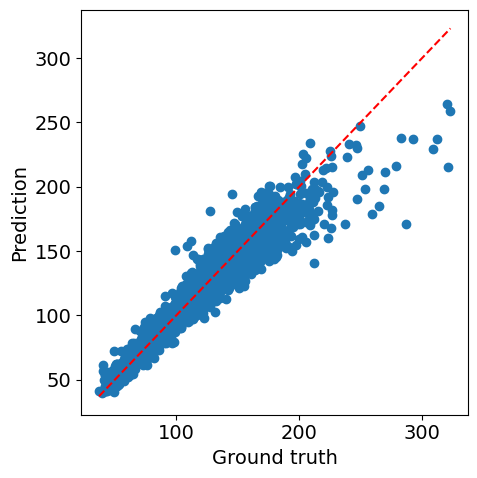

In [22]:
# Set the default font size
plt.rcParams['font.size'] = 14

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(y_test, f_mean.numpy().flatten(), 'o')
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
ax.set_xlabel('Ground truth')
ax.set_ylabel('Prediction')

plt.tight_layout()

### 3. Propose solutions

In [23]:
# Compose dataset
Q1, Q2 = 300, 200
Q1_array, Q2_array = Q1*np.ones((df_candidates.shape[0], 1)), Q2*np.ones((df_candidates.shape[0], 1))
X_candidates = df_candidates.to_numpy()
X_candidates = np.hstack((Q1_array, Q2_array, X_candidates))
X_candidates_scaled = scaler.transform(X_candidates)

#### Calculate weights

In [24]:
def evaluate_weight(X):
    # Properties
    density_Al = 2700
    Fan_height = 40e-3
    Fan_Weight = 50.8e-3
    N_fan = np.ceil(X[:, 3] / Fan_height)

    # Weight calculation
    w = density_Al*(X[:, 3]*X[:, 2]*X[:, 4]+X[:, 7]*(X[:, 5]*X[:, 8]*X[:, 4]))+ Fan_Weight*N_fan

    return w

In [25]:
w = evaluate_weight(X_candidates)

#### GP propsal

In [27]:
# GP prediction
f_mean, f_var = model.predict_f(X_candidates_scaled, full_cov=False)
f_mean = f_mean.numpy().flatten()
f_var = f_var.numpy().flatten()

In [28]:
Tjmax = 175
likelihood = norm.cdf(Tjmax, loc=f_mean, scale=np.sqrt(f_var))
utility = likelihood*1/w

In [29]:
# Sort candidates
df_candidates = pd.DataFrame(X_candidates)
df_candidates.columns = ['Q1', 'Q2', 'd', 'b', 'L', 'c', 'L_duct', 'n', 't', 'xc1', 'yc1', 'xc2', 'yc2']
df_candidates['weight'] = w
df_candidates['pred_T'] = f_mean
df_candidates['utility'] = utility
df_candidates_sorted = df_candidates.sort_values(by='utility', ascending=False).reset_index(drop=True)

In [30]:
df_candidates_sorted.head(20)

,Q1,Q2,d,b,L,c,L_duct,n,t,xc1,yc1,xc2,yc2,weight,pred_T,utility
0,300.0,200.0,0.005036,0.135006,0.130851,0.017313,0.020918,20.0,0.001064,0.101107,0.072332,0.031513,0.074614,0.573617,136.119828,1.743323
1,300.0,200.0,0.005097,0.151972,0.142751,0.010137,0.023378,21.0,0.001005,0.052377,0.058127,0.117745,0.085821,0.584163,152.731021,1.711812
2,300.0,200.0,0.006343,0.083324,0.215728,0.011678,0.021281,16.0,0.001204,0.044877,0.161781,0.045595,0.053816,0.591296,151.373540,1.691173
3,300.0,200.0,0.005449,0.139620,0.143813,0.013428,0.020433,13.0,0.001388,0.101022,0.061304,0.033435,0.066809,0.592700,156.521863,1.686134
4,300.0,200.0,0.005372,0.076785,0.233001,0.011372,0.041476,28.0,0.001199,0.032328,0.166979,0.036253,0.056686,0.601333,148.964663,1.662968
5,300.0,200.0,0.005376,0.129205,0.130588,0.014053,0.025473,20.0,0.001665,0.094844,0.071190,0.031439,0.053863,0.613036,145.186621,1.631225
6,300.0,200.0,0.005479,0.129037,0.156328,0.011975,0.036597,19.0,0.001207,0.030707,0.076463,0.097595,0.071899,0.617572,150.156737,1.619245
7,300.0,200.0,0.005973,0.078182,0.238093,0.010574,0.028617,25.0,0.001288,0.031255,0.184098,0.032540,0.067025,0.620688,153.322786,1.611016
8,300.0,200.0,0.005411,0.076717,0.259426,0.013136,0.043931,13.0,0.001920,0.040594,0.080268,0.040617,0.200812,0.622080,153.369632,1.607441
9,300.0,200.0,0.005244,0.075271,0.249366,0.021708,0.042282,11.0,0.001595,0.036786,0.060101,0.039533,0.176455,0.623812,135.420646,1.603048


In [ ]:
trial_index = 0
print(f"Predicted temperature: {df_candidates_sorted.loc[trial_index, 'pred_T']}")
df_candidates_sorted.iloc[trial_index, 2:-3].to_numpy()

In [31]:
def check_constraints(X):

    # Dimension
    c_module, d_module = 61.4e-3, 106e-3
    
    # Position
    Xc_min = c_module / 2
    Xc_max = X[3] - c_module / 2
    Yc_min = d_module / 2
    Yc_max = X[4] - d_module / 2
    
    con1 = X[8] < X[3] / X[7] - 1e-3     # For t
    con2 = (X[-4] < Xc_max) and (X[-4] > Xc_min) and (X[-3] < Yc_max) and (X[-3] > Yc_min)
    con3 = (X[-2] < Xc_max) and (X[-2] > Xc_min) and (X[-1] < Yc_max) and (X[-1] > Yc_min)
    con4 = (np.abs(X[-4] - X[-2]) > c_module) | (np.abs(X[-3] - X[-1]) > d_module)
    return con1 and con2 and con3 and con4

In [33]:
check_constraints(df_candidates_sorted.iloc[10, :].to_numpy()[:-3])

True

In [35]:
# Save the proposal
df_candidates_sorted.iloc[:50, :].to_csv(f'./dataset/{Q1}_{Q2}_proposal.csv', index=False)